In [1]:
import torch
import torch.nn as nn

##  Setting Up the Generator

In [2]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, output_dim),
            nn.Sigmoid()  # Normalize to [0,1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)  # Reshape to (batch_size, 1, 28, 28)
        return img

# Test generator
gen = Generator()
print(gen)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


## Setting up Discriminator

In [3]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_dim=784):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)  # No activation function
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        validity = self.model(img_flat)  # Output a single scalar
        return validity

# Test discriminator
disc = Discriminator()
print(disc)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


## Gradient Penalty Calculation

In [4]:
# Gradient Penalty Function
def gradient_penalty(discriminator, real_samples, fake_samples, lambda_gp=10, device='cuda'):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    
    interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    
    # Gradient calculation
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size(), device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Gradient Penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty


## Training Loop

In [7]:
import torch.optim as optim

# Hyperparameters
n_critic = 5  # Number of iterations of the discriminator per generator update
lambda_gp = 10  # Gradient penalty lambda hyperparameter
epochs = 100
batch_size = 64
latent_dim = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

# Dataset and Dataloader (FashionMNIST)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Lists to track training losses
d_losses = []
g_losses = []
wasserstein_losses = []
gp_losses = []

# Training WGAN-GP
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        
        # Train Discriminator
        for _ in range(n_critic):
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z)
            
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs.detach())
            gp = gradient_penalty(discriminator, real_imgs.data, fake_imgs.data, lambda_gp, device)
            
            wasserstein_loss = fake_validity.mean() - real_validity.mean()
            d_loss = wasserstein_loss + gp
            
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        # Train Generator
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        fake_validity = discriminator(fake_imgs)
        
        g_loss = -fake_validity.mean()
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    # Logging losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    wasserstein_losses.append(wasserstein_loss.item())
    gp_losses.append(gp.item())

    # Print losses for the current epoch
    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [Wasserstein Loss: {wasserstein_loss.item()}] [GP Loss: {gp.item()}]")


[Epoch 0/100] [D loss: -39.721988677978516] [G loss: -1.9415802955627441] [Wasserstein Loss: -57.1975212097168] [GP Loss: 17.47553253173828]
[Epoch 1/100] [D loss: -40.392127990722656] [G loss: 25.651416778564453] [Wasserstein Loss: -55.44335174560547] [GP Loss: 15.051223754882812]
[Epoch 2/100] [D loss: -37.452362060546875] [G loss: 46.54737091064453] [Wasserstein Loss: -68.33704376220703] [GP Loss: 30.884681701660156]
[Epoch 3/100] [D loss: -48.1121711730957] [G loss: 76.49496459960938] [Wasserstein Loss: -78.5628890991211] [GP Loss: 30.45071792602539]
[Epoch 4/100] [D loss: -42.63953399658203] [G loss: 104.37528991699219] [Wasserstein Loss: -59.58966827392578] [GP Loss: 16.950132369995117]
[Epoch 5/100] [D loss: -47.51760482788086] [G loss: 121.89442443847656] [Wasserstein Loss: -64.7312240600586] [GP Loss: 17.213619232177734]
[Epoch 6/100] [D loss: -39.280147552490234] [G loss: 128.39764404296875] [Wasserstein Loss: -64.31795501708984] [GP Loss: 25.03780746459961]
[Epoch 7/100] [D 

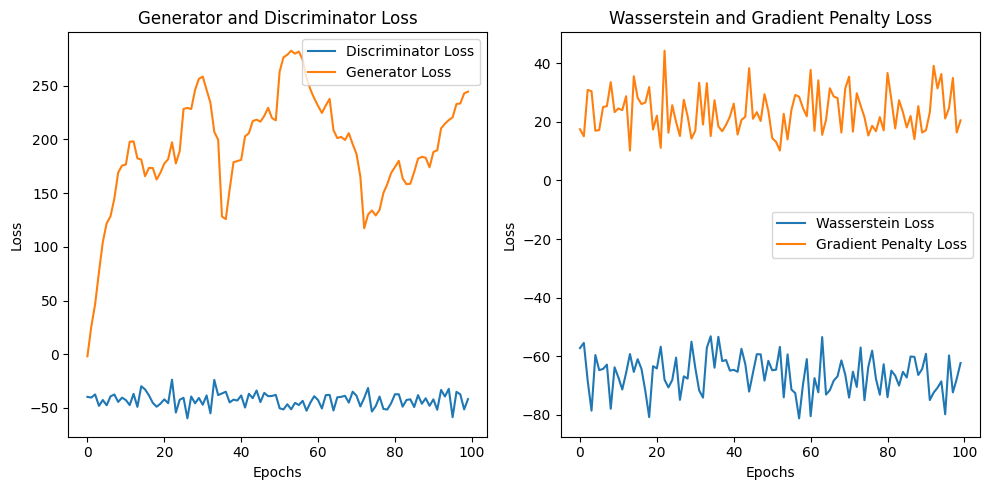

In [8]:
import matplotlib.pyplot as plt

# Plotting training curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(wasserstein_losses, label="Wasserstein Loss")
plt.plot(gp_losses, label="Gradient Penalty Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Wasserstein and Gradient Penalty Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Generating Images for Evaluation

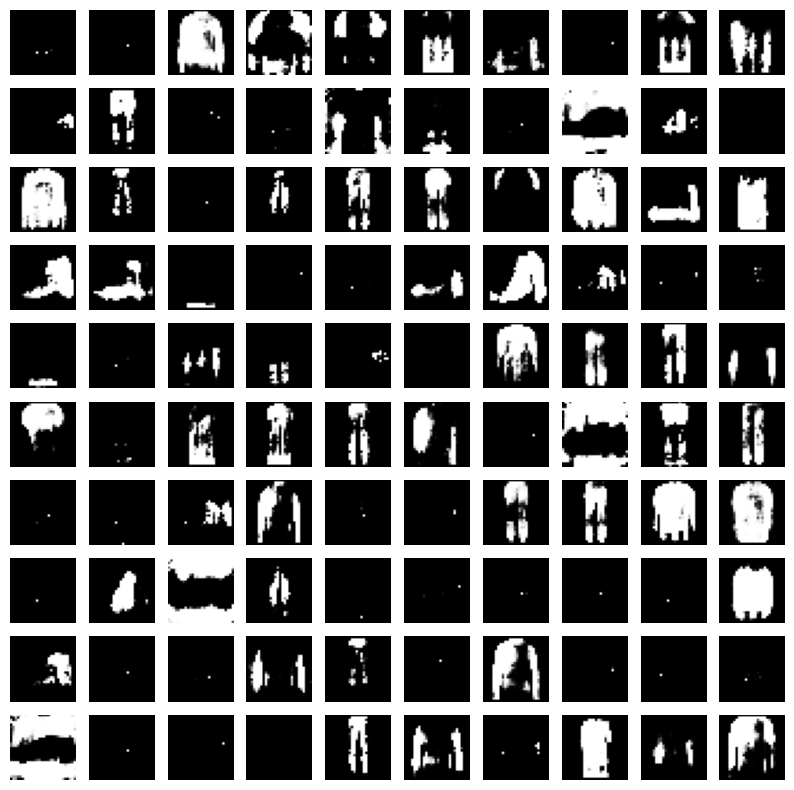

In [6]:
import matplotlib.pyplot as plt

# Generate and display images from the generator
def generate_images(generator, n_images=100):
    z = torch.randn(n_images, latent_dim).to(device)
    gen_imgs = generator(z).cpu().detach().numpy()
    return gen_imgs

# Plot the generated images in a 10x10 grid
gen_imgs = generate_images(generator, n_images=100)
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        axs[i, j].imshow(gen_imgs[i * 10 + j].reshape(28, 28), cmap='gray')
        axs[i, j].axis('off')

plt.show()


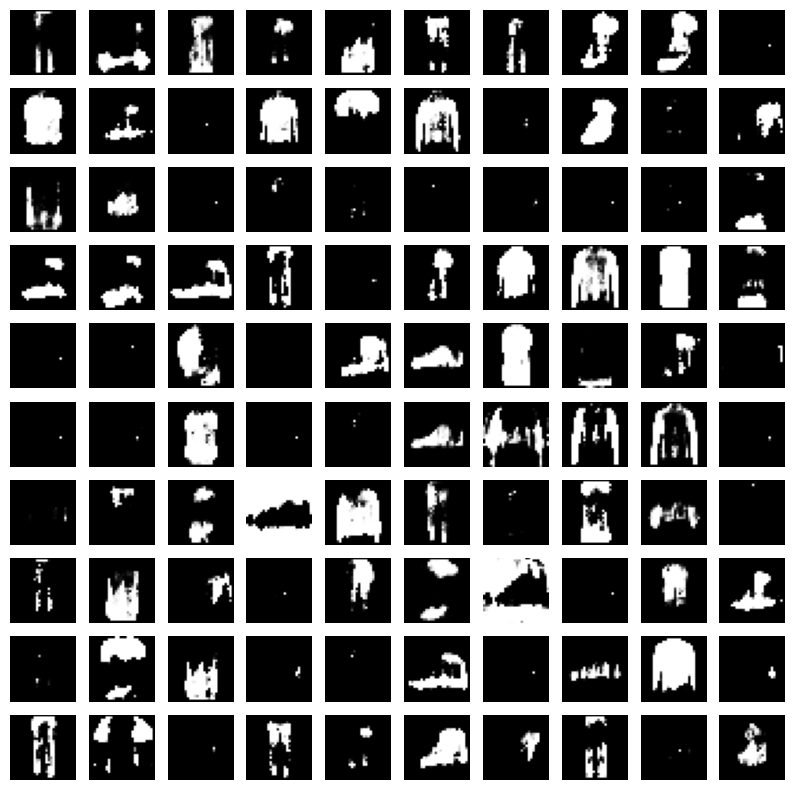

In [9]:
import matplotlib.pyplot as plt

# Generate and display images from the generator
def generate_images(generator, n_images=100):
    z = torch.randn(n_images, latent_dim).to(device)
    gen_imgs = generator(z).cpu().detach().numpy()
    return gen_imgs

# Plot the generated images in a 10x10 grid
gen_imgs = generate_images(generator, n_images=100)
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        axs[i, j].imshow(gen_imgs[i * 10 + j].reshape(28, 28), cmap='gray')
        axs[i, j].axis('off')

plt.show()
